# Stock Prediction Model - Binary Classification

## Bài toán: Dự đoán tín hiệu MUA cổ phiếu
- **Target = 1**: Nên MUA (Future_Return_7d > 2%)
- **Target = 0**: KHÔNG MUA (Future_Return_7d ≤ 2%)

## Đặc điểm dữ liệu:
- Time series data theo từng mã cổ phiếu
- Cần chia train/test theo thời gian (không shuffle)
- Binary Classification: Tập trung vào tín hiệu MUA chất lượng cao
- Model: Random Forest & LightGBM Classifier

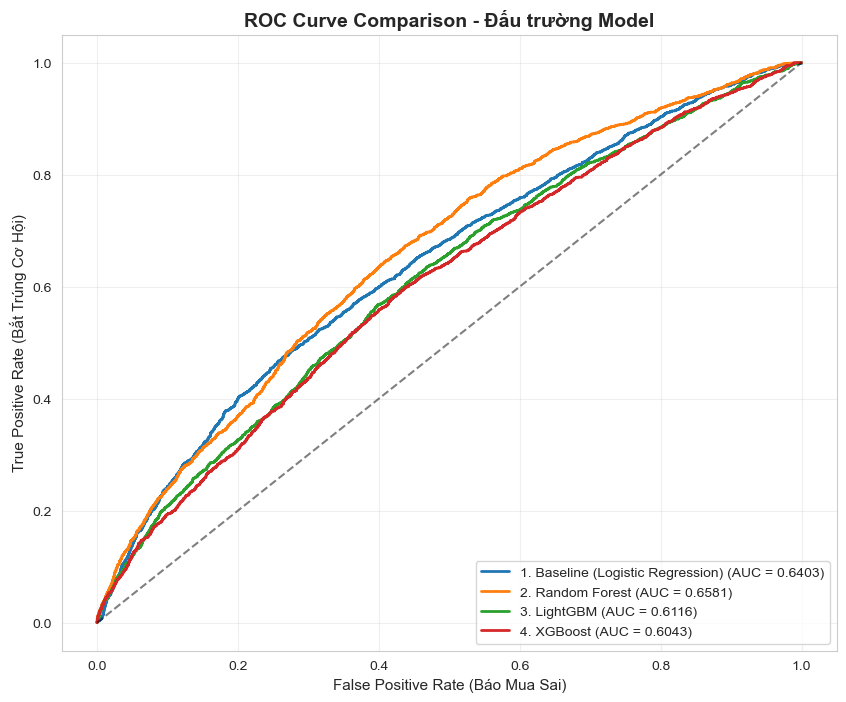

🕵️‍♀️ DEEP DIVE INTO WINNER: 2. Random Forest


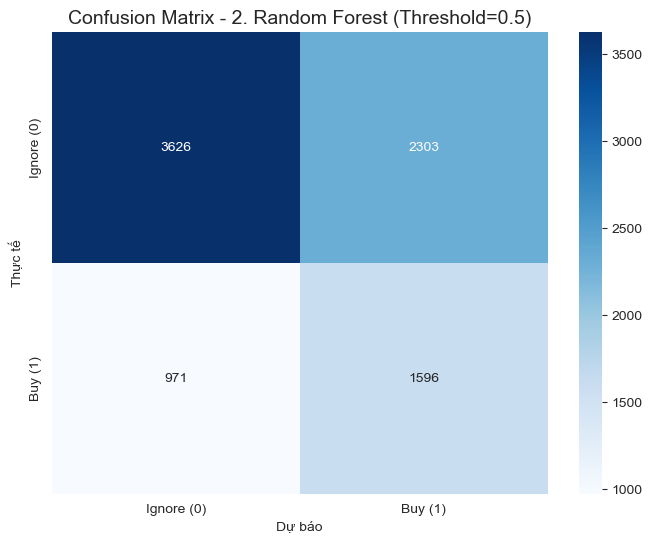


📋 SƠ BỘ HIỆU NĂNG (Ở ngưỡng mặc định 0.5):
              precision    recall  f1-score   support

      Ignore       0.79      0.61      0.69      5929
         Buy       0.41      0.62      0.49      2567

    accuracy                           0.61      8496
   macro avg       0.60      0.62      0.59      8496
weighted avg       0.67      0.61      0.63      8496


⚠️ LƯU Ý QUAN TRỌNG:
- Kết quả trên chỉ là ở ngưỡng 0.5 mặc định.
- Đừng lo nếu Precision thấp, chúng ta sẽ tối ưu Threshold ở bước tiếp theo!


In [311]:
# ==========================================
# 1. SO SÁNH ROC CURVE (TẤT CẢ MODEL)
# ==========================================
plt.figure(figsize=(10, 8))

for name, result in model_results.items():
    model = result['model']
    # Lấy xác suất từ kết quả đã lưu
    y_scores = result['val_probs'] 
    
    # Tính FPR, TPR
    fpr, tpr, _ = roc_curve(y_val, y_scores)
    auc_score = result['val_auc']
    
    plt.plot(fpr, tpr, label=f'{name} (AUC = {auc_score:.4f})', linewidth=2)

# Đường chéo tham chiếu (Random Guess)
plt.plot([0, 1], [0, 1], 'k--', alpha=0.5)
plt.xlabel('False Positive Rate (Báo Mua Sai)', fontsize=11)
plt.ylabel('True Positive Rate (Bắt Trúng Cơ Hội)', fontsize=11)
plt.title('ROC Curve Comparison - Đấu trường Model', fontsize=14, fontweight='bold')
plt.legend(loc='lower right')
plt.grid(alpha=0.3)
plt.show()

# ==========================================
# 2. PHÂN TÍCH CHI TIẾT BEST MODEL (WINNER)
# ==========================================
print("="*60)
print(f"🕵️‍♀️ DEEP DIVE INTO WINNER: {best_model_name}")
print("="*60)

# Lấy thông tin model thắng cuộc
winner_probs = model_results[best_model_name]['val_probs']

# Dự đoán tạm thời ở ngưỡng 0.5 để xem sơ bộ
y_pred_temp = (winner_probs >= 0.5).astype(int)

# A. Confusion Matrix
cm = confusion_matrix(y_val, y_pred_temp)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Ignore (0)', 'Buy (1)'],
            yticklabels=['Ignore (0)', 'Buy (1)'])
plt.title(f'Confusion Matrix - {best_model_name} (Threshold=0.5)', fontsize=14)
plt.ylabel('Thực tế')
plt.xlabel('Dự báo')
plt.show()

# B. Classification Report
print("\n📋 SƠ BỘ HIỆU NĂNG (Ở ngưỡng mặc định 0.5):")
print(classification_report(y_val, y_pred_temp, target_names=['Ignore', 'Buy']))

print("\n⚠️ LƯU Ý QUAN TRỌNG:")
print("- Kết quả trên chỉ là ở ngưỡng 0.5 mặc định.")
print("- Đừng lo nếu Precision thấp, chúng ta sẽ tối ưu Threshold ở bước tiếp theo!")

In [312]:
# Import libraries
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score,  roc_curve, auc, roc_auc_score
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
import lightgbm as lgb
import xgboost as xgb
import time
import warnings
warnings.filterwarnings('ignore')

# Set style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)


## 1. Load Data

In [313]:
# Load data (technical indicators only, without target)
INPUT_PATH = Path("../data/processed/ta/ta_data_technical_indicators.csv")
df = pd.read_csv(INPUT_PATH)

# Convert time to datetime
df['time'] = pd.to_datetime(df['time'])

print(f"📊 Dataset shape: {df.shape}")
print(f"📅 Time range: {df['time'].min()} to {df['time'].max()}")
print(f"📈 Number of stocks: {df['symbol'].nunique()}")

df.head()


📊 Dataset shape: (66322, 32)
📅 Time range: 2023-01-03 00:00:00 to 2025-10-31 00:00:00
📈 Number of stocks: 100


,time,open,high,low,close,volume,symbol,price_range,price_range_pct,body_size_pct,...,volume_ratio,obv,plus_di,minus_di,adx,Volume_Spike,RSI_Oversold,RSI_Overbought,Price_Above_MA20,Price_Above_MA50
0,2023-01-03,11.28,11.28,11.00,11.19,3601,AAM,0.28,2.545455,0.797872,...,1.000000,0.0,0.000000,0.000000,NaN,0,0,0,0,0
1,2023-01-04,10.67,11.00,10.67,10.91,3900,AAM,0.33,3.092784,2.249297,...,1.039861,-3900.0,0.000000,41.250000,100.0,0,1,0,0,0
2,2023-01-05,10.44,11.19,10.44,11.19,2332,AAM,0.75,7.183908,7.183908,...,0.711482,-1568.0,0.000000,36.129032,100.0,0,0,0,1,1
3,2023-01-06,11.00,11.14,10.96,10.96,600,AAM,0.18,1.642336,0.363636,...,0.230039,-2168.0,0.000000,31.460674,100.0,0,0,0,0,0
4,2023-01-09,11.28,11.28,10.91,10.96,441,AAM,0.37,3.391384,2.836879,...,0.202777,-2168.0,6.511628,26.046512,90.0,0,0,0,0,0


In [314]:
# Sort by symbol and time to ensure correct order
df = df.sort_values(['symbol', 'time']).reset_index(drop=True)

# Calculate Future Return for each stock
def calculate_future_return(group):
    # Shift close price up by 7 days (price after 7 days)
    group['Future_Close'] = group['close'].shift(-7)
    # Calculate % return (in decimal: 0.02 = 2%)
    group['Future_Return_7d'] = (group['Future_Close'] - group['close']) / group['close']
    return group

df = df.groupby('symbol', group_keys=False).apply(calculate_future_return)

print("✅ Future_Return_7d calculated successfully.")
print(f"   Non-NaN values: {df['Future_Return_7d'].notna().sum()}")
print(f"   NaN values (last 7 days per stock): {df['Future_Return_7d'].isna().sum()}")
print(f"\n📊 Future Return statistics (decimal format):")
print(df['Future_Return_7d'].describe())


✅ Future_Return_7d calculated successfully.
   Non-NaN values: 65622
   NaN values (last 7 days per stock): 700

📊 Future Return statistics (decimal format):
count    65622.000000
mean         0.006034
std          0.070070
min         -0.495327
25%         -0.023762
50%          0.000000
75%          0.028388
max          1.119388
Name: Future_Return_7d, dtype: float64


In [315]:
# Create Binary Target variable:
# 1 = BUY (return > 2% after 7 days)
# 0 = DON'T BUY (return <= 2% after 7 days)

def classify_target(row):
    # Handle NaN Future_Return_7d (last 7 days of data)
    if pd.isna(row['Future_Return_7d']):
        return np.nan
        
    if row['Future_Return_7d'] > 0.02:  # 5% in decimal
        return 1  # BUY - High profit potential
    else:
        return 0  # DON'T BUY - Low profit or loss

df['Target'] = df.apply(classify_target, axis=1)

print("✅ Binary Target variable created successfully.")
print(f"   NaN Targets (last 7 days): {df['Target'].isna().sum()}")
print(f"\n🎯 Target distribution:")
print(df['Target'].value_counts().sort_index())
print(f"\n📋 Target distribution (%):")
print(df['Target'].value_counts(normalize=True).sort_index() * 100)


✅ Binary Target variable created successfully.
   NaN Targets (last 7 days): 700

🎯 Target distribution:
Target
0.0    45850
1.0    19772
Name: count, dtype: int64

📋 Target distribution (%):
Target
0.0    69.869861
1.0    30.130139
Name: proportion, dtype: float64


### 1.2 Create Target Variable - Future Return 7 days

In [316]:
# Feature Engineering: Thêm các chỉ báo kỹ thuật phái sinh

# 1. Volume Spike: Khối lượng tăng đột biến (> 1.5 lần trung bình)
if 'volume_ratio' in df.columns:
    df['Volume_Spike'] = (df['volume_ratio'] > 1.5).astype(int)
else:
    print("⚠️ Warning: 'volume_ratio' not found.")

# 2. RSI Signals
if 'rsi_14' in df.columns:
    df['RSI_Oversold'] = (df['rsi_14'] < 30).astype(int)
    df['RSI_Overbought'] = (df['rsi_14'] > 70).astype(int)
else:
    print("⚠️ Warning: 'rsi_14' not found.")

# 3. Price vs MA (Trend indicators)
if 'ma_20_divergence' in df.columns:
    df['Price_Above_MA20'] = (df['ma_20_divergence'] > 0).astype(int)

if 'ma_50_divergence' in df.columns:
    df['Price_Above_MA50'] = (df['ma_50_divergence'] > 0).astype(int)

print("✅ Added derived features: Volume_Spike, RSI_Signals, Price_Above_MA")


✅ Added derived features: Volume_Spike, RSI_Signals, Price_Above_MA


## 2. Data Preparation & Feature Engineering

In [317]:
# Remove rows with NaN target (last 7 days of each stock)
df_clean = df.dropna(subset=['Target']).copy()

# Sort by symbol and time to maintain time series order
df_clean = df_clean.sort_values(['symbol', 'time']).reset_index(drop=True)

print(f"✅ Clean dataset shape: {df_clean.shape}")
print(f"❌ Removed {len(df) - len(df_clean)} rows with NaN target")
print(f"\n🎯 Target distribution after cleaning:")
print(df_clean['Target'].value_counts().sort_index())


✅ Clean dataset shape: (65622, 35)
❌ Removed 700 rows with NaN target

🎯 Target distribution after cleaning:
Target
0.0    45850
1.0    19772
Name: count, dtype: int64


In [318]:
# Define feature columns (exclude non-feature columns)
# IMPORTANT: Exclude ALL future data to prevent data leakage!
exclude_cols = ['time', 'symbol', 'Future_Return_7d', 'Future_Close', 'Target']
feature_cols = [col for col in df_clean.columns if col not in exclude_cols]

print(f"📊 Number of features: {len(feature_cols)}")
print(f"\n📋 Feature list:")
for i, col in enumerate(feature_cols, 1):
    print(f"{i:2d}. {col}")


📊 Number of features: 30

📋 Feature list:
 1. open
 2. high
 3. low
 4. close
 5. volume
 6. price_range
 7. price_range_pct
 8. body_size_pct
 9. ma_5_divergence
10. ma_20_divergence
11. ma_50_divergence
12. rsi_14
13. macd
14. macd_histogram
15. stochastic_k
16. volatility_20
17. atr_14
18. bb_width
19. bb_position
20. volume_ma_20
21. volume_ratio
22. obv
23. plus_di
24. minus_di
25. adx
26. Volume_Spike
27. RSI_Oversold
28. RSI_Overbought
29. Price_Above_MA20
30. Price_Above_MA50


## 3. Time-Series Aware Train/Test Split

In [319]:
def time_series_split_with_gap(df, train_ratio=0.7, val_ratio=0.15, gap_days=7):
    """
    Chia dữ liệu thành 3 tập: TRAIN - VALIDATION - TEST
    Có khoảng hở (Gap) giữa các tập để tránh Data Leakage từ biến Target (7 ngày).
    
    Structure: [TRAIN] --gap-- [VALIDATION] --gap-- [TEST]
    """
    # Find global time range
    min_date = df['time'].min()
    max_date = df['time'].max()
    total_days = (max_date - min_date).days
    
    # 1. Tính toán điểm cắt cho Validation
    train_end_days = int(total_days * train_ratio)
    val_start_date = min_date + pd.Timedelta(days=train_end_days)
    
    # 2. Tính toán điểm cắt cho Test
    val_end_days = int(total_days * (train_ratio + val_ratio))
    test_start_date = min_date + pd.Timedelta(days=val_end_days)
    
    print(f"📅 Global Time Range: {min_date.date()} to {max_date.date()}")
    
    # --- SPLIT WITH GAP ---
    # Train: Từ đầu đến (Val Start - Gap)
    train_end_date = val_start_date - pd.Timedelta(days=gap_days)
    train_df = df[df['time'] <= train_end_date].copy()
    
    # Validation: Từ Val Start đến (Test Start - Gap)
    val_end_date = test_start_date - pd.Timedelta(days=gap_days)
    val_df = df[(df['time'] >= val_start_date) & (df['time'] <= val_end_date)].copy()
    
    # Test: Từ Test Start đến hết
    test_df = df[df['time'] >= test_start_date].copy()
    
    return train_df, val_df, test_df

# ==========================================
# ÁP DỤNG
# ==========================================
# Chia theo tỷ lệ: Train 70% | Val 15% | Test 15%
# Gap = 7 ngày (vì target là Future_Return_7d)
train_df, val_df, test_df = time_series_split_with_gap(
    df_clean, 
    train_ratio=0.7, 
    val_ratio=0.15, 
    gap_days=7
)

# --- IN KẾT QUẢ KIỂM TRA ---
print("-" * 60)
print(f"📊 TRAIN SET: {train_df.shape}")
print(f"   Range: {train_df['time'].min().date()} -> {train_df['time'].max().date()}")
print(f"   Target 1 ratio: {train_df['Target'].mean():.2%}")

print("-" * 60)
print(f"📊 VAL SET:   {val_df.shape} (Dùng để chỉnh Threshold/Chọn Model)")
print(f"   Range: {val_df['time'].min().date()} -> {val_df['time'].max().date()}")
print(f"   Target 1 ratio: {val_df['Target'].mean():.2%}")

print("-" * 60)
print(f"📊 TEST SET:  {test_df.shape} (Dùng để Backtest lợi nhuận)")
print(f"   Range: {test_df['time'].min().date()} -> {test_df['time'].max().date()}")
print(f"   Target 1 ratio: {test_df['Target'].mean():.2%}")

print("-" * 60)
print("✅ KIỂM TRA GAP (CHỐNG LEAKAGE):")
gap_train_val = (val_df['time'].min() - train_df['time'].max()).days
gap_val_test = (test_df['time'].min() - val_df['time'].max()).days
print(f"   Gap Train -> Val: {gap_train_val} days (Yêu cầu > 7) -> {'OK' if gap_train_val >=7 else 'FAIL'}")
print(f"   Gap Val   -> Test: {gap_val_test} days (Yêu cầu > 7) -> {'OK' if gap_val_test >=7 else 'FAIL'}")

# ==========================================
# PREPARE X, y
# ==========================================
X_train = train_df[feature_cols]
y_train = train_df['Target']

X_val = val_df[feature_cols]
y_val = val_df['Target']

X_test = test_df[feature_cols]
y_test = test_df['Target']

# Handle missing values (Imputation)
# Lưu ý: Luôn dùng median của tập TRAIN để điền cho Val và Test (tránh leakage)
train_median = X_train.median()

X_train = X_train.fillna(train_median)
X_val = X_val.fillna(train_median)
X_test = X_test.fillna(train_median)

print("\n✅ Data preparation complete!")
print(f"X_train: {X_train.shape}, X_val: {X_val.shape}, X_test: {X_test.shape}")

📅 Global Time Range: 2023-01-03 to 2025-10-22
------------------------------------------------------------
📊 TRAIN SET: (47189, 35)
   Range: 2023-01-03 -> 2024-12-12
   Target 1 ratio: 29.87%
------------------------------------------------------------
📊 VAL SET:   (8496, 35) (Dùng để chỉnh Threshold/Chọn Model)
   Range: 2024-12-19 -> 2025-05-14
   Target 1 ratio: 30.21%
------------------------------------------------------------
📊 TEST SET:  (9216, 35) (Dùng để Backtest lợi nhuận)
   Range: 2025-05-21 -> 2025-10-22
   Target 1 ratio: 31.18%
------------------------------------------------------------
✅ KIỂM TRA GAP (CHỐNG LEAKAGE):
   Gap Train -> Val: 7 days (Yêu cầu > 7) -> OK
   Gap Val   -> Test: 7 days (Yêu cầu > 7) -> OK

✅ Data preparation complete!
X_train: (47189, 30), X_val: (8496, 30), X_test: (9216, 30)


## 4. Model Training

In [326]:
# ==========================================
# PHASE 2: THE TOURNAMENT (ĐẤU TRƯỜNG MODEL)
# ==========================================

# 1. Dictionary lưu kết quả
model_results = {}

# 2. Hàm Train đa năng (Đã nâng cấp để lưu History cho Random Forest)
def train_evaluate_model(model_name, model_obj, X_train, y_train, X_val, y_val):
    print(f"\n🚀 TRAINING: {model_name}...")
    start_time = time.time()
    
    history = {} # Nơi chứa nhật ký học tập
    
    # ====================================================
    # CASE A: RANDOM FOREST (Thủ công tạo vòng lặp ghi nhật ký)
    # ====================================================
    if 'Random Forest' in model_name:
        # Bật chế độ warm_start để học nối tiếp
        model_obj.set_params(warm_start=True)
        final_n_estimators = model_obj.n_estimators
        
        # Tạo list lưu trữ
        history = {'train_auc': [], 'val_auc': [], 'train_loss': [], 'val_loss': []}
        
        # Chạy vòng lặp (ví dụ mỗi bước tăng 5 cây)
        # Bước nhảy nhỏ thì vẽ hình mượt, nhưng train lâu hơn xíu
        steps = list(range(1, final_n_estimators + 1, 2)) 
        if final_n_estimators not in steps: steps.append(final_n_estimators)
        
        # Reset model về 0 để bắt đầu học
        model_obj.set_params(n_estimators=1)
        
        print(f"   recording progress...", end='')
        for i in steps:
            model_obj.set_params(n_estimators=i)
            model_obj.fit(X_train, y_train)
            
            # Ghi lại metric
            # 1. AUC
            tr_auc = roc_auc_score(y_train, model_obj.predict_proba(X_train)[:, 1])
            val_auc = roc_auc_score(y_val, model_obj.predict_proba(X_val)[:, 1])
            history['train_auc'].append(tr_auc)
            history['val_auc'].append(val_auc)
            
            # 2. Loss (Thêm cái này để chiều ý thầy của bạn luôn)
            tr_loss = log_loss(y_train, model_obj.predict_proba(X_train))
            val_loss = log_loss(y_val, model_obj.predict_proba(X_val))
            history['train_loss'].append(tr_loss)
            history['val_loss'].append(val_loss)
            
        print(" Done!")

    # ====================================================
    # CASE B: XGBOOST (Dùng cơ chế có sẵn)
    # ====================================================
    elif 'XGB' in model_name:
        model_obj.fit(
            X_train, y_train,
            eval_set=[(X_train, y_train), (X_val, y_val)],
            verbose=False
        )
        # Chuẩn hóa format history để giống RF
        raw_hist = model_obj.evals_result()
        history = {
            'train_auc': raw_hist['validation_0']['auc'],
            'val_auc': raw_hist['validation_1']['auc']
            # XGB mặc định ko lưu loss nếu metric='auc', nhưng auc là đủ để vẽ rồi
        }
        
    # ====================================================
    # CASE C: LIGHTGBM (Dùng cơ chế có sẵn)
    # ====================================================
    elif 'LightGBM' in model_name:
        model_obj.fit(
            X_train, y_train,
            eval_set=[(X_train, y_train), (X_val, y_val)],
            eval_metric='auc',
            callbacks=[lgb.log_evaluation(period=0)]
        )
        # Chuẩn hóa format history
        raw_hist = model_obj.evals_result_
        metric_key = list(raw_hist['training'].keys())[0] # Lấy tên metric (auc)
        history = {
            'train_auc': raw_hist['training'][metric_key],
            'val_auc': raw_hist['valid_1'][metric_key]
        }
            
    # ====================================================
    # CASE D: LOGISTIC REGRESSION (Fit bình thường)
    # ====================================================
    else:
        model_obj.fit(X_train, y_train)
        history = None # Không có khái niệm epoch
        
    # --- TÍNH ĐIỂM TỔNG KẾT ---
    y_train_prob = model_obj.predict_proba(X_train)[:, 1]
    y_val_prob = model_obj.predict_proba(X_val)[:, 1]
    
    train_auc = roc_auc_score(y_train, y_train_prob)
    val_auc = roc_auc_score(y_val, y_val_prob)
    
    elapsed = time.time() - start_time
    print(f"   ⏱️ Time: {elapsed:.2f}s")
    print(f"   📈 Train AUC: {train_auc:.4f} | Val AUC: {val_auc:.4f}")
    
    # Lưu kết quả
    model_results[model_name] = {
        'model': model_obj,
        'val_auc': val_auc,
        'val_probs': y_val_prob,
        'history': history, # <--- GIỜ ĐÂY RF ĐÃ CÓ HISTORY XỊN
        'train_auc': train_auc
    }
    
    return model_obj

# ==========================================
# 3. KHỞI TẠO VÀ CHẠY CÁC MODEL
# ==========================================

# Model 1: Logistic Regression (Baseline)
# Lưu ý: LR cần Scale dữ liệu, nên dùng Pipeline để gói gọn
lr_model = make_pipeline(
    StandardScaler(), 
    LogisticRegression(class_weight='balanced', random_state=42, max_iter=1000)
)

# Model 2: Random Forest
# warm_start=True: QUAN TRỌNG để vẽ Learning Curve ở bước sau
rf_model = RandomForestClassifier(
    n_estimators=100,
    warm_start=True,       
    max_depth=8,           # Giảm depth để đỡ overfit
    min_samples_leaf=20,   # Tăng lên để tổng quát hơn
    class_weight='balanced',
    random_state=42,
    n_jobs=-1
)

# Model 3: LightGBM
lgbm_model = lgb.LGBMClassifier(
    n_estimators=200,
    learning_rate=0.03, # Learning rate nhỏ học chậm mà chắc
    max_depth=6,
    num_leaves=20,
    class_weight='balanced',
    random_state=42,
    n_jobs=-1,
    verbose=-1
)

# Model 4: XGBoost
# Tính scale_pos_weight cho XGBoost (số lượng mẫu 0 / số lượng mẫu 1)
neg_pos_ratio = (y_train == 0).sum() / (y_train == 1).sum()
xgb_model = xgb.XGBClassifier(
    n_estimators=200,
    learning_rate=0.03,
    max_depth=6,
    scale_pos_weight=neg_pos_ratio, # Xử lý mất cân bằng mẫu
    random_state=42,
    n_jobs=-1,
    eval_metric='auc',
    verbosity=0
)

# --- CHẠY VÒNG LẶP ---
# List các model cần train
models_to_train = [
    ('1. Baseline (Logistic Regression)', lr_model),
    ('2. Random Forest', rf_model),
    ('3. LightGBM', lgbm_model),
    ('4. XGBoost', xgb_model)
]

print("="*60)
print("STARTING MODEL TOURNAMENT...")
print("="*60)

for name, model in models_to_train:
    train_evaluate_model(name, model, X_train, y_train, X_val, y_val)

# ==========================================
# 4. TỔNG KẾT BẢNG XẾP HẠNG (LEADERBOARD)
# ==========================================
print("\n" + "="*60)
print("🏆 FINAL LEADERBOARD (Sorted by Validation AUC)")
print("="*60)

# Chuyển thành DataFrame để sort cho đẹp
results_df = pd.DataFrame(model_results).T
results_df = results_df[['train_auc', 'val_auc']]
results_df['overfit_gap'] = results_df['train_auc'] - results_df['val_auc']
results_df = results_df.sort_values('val_auc', ascending=False)

print(results_df)

# Chọn ra Best Model tự động
best_model_name = results_df.index[0]
best_model = model_results[best_model_name]['model']
print(f"\n🥇 WINNER: {best_model_name}")

STARTING MODEL TOURNAMENT...

🚀 TRAINING: 1. Baseline (Logistic Regression)...
   ⏱️ Time: 0.23s
   📈 Train AUC: 0.6087 | Val AUC: 0.6403

🚀 TRAINING: 2. Random Forest...
   recording progress... Done!
   ⏱️ Time: 19.57s
   📈 Train AUC: 0.7298 | Val AUC: 0.6581

🚀 TRAINING: 3. LightGBM...
   ⏱️ Time: 2.09s
   📈 Train AUC: 0.7379 | Val AUC: 0.6116

🚀 TRAINING: 4. XGBoost...
   ⏱️ Time: 1.31s
   📈 Train AUC: 0.7922 | Val AUC: 0.6043

🏆 FINAL LEADERBOARD (Sorted by Validation AUC)
                                  train_auc   val_auc overfit_gap
2. Random Forest                   0.729763  0.658135    0.071629
1. Baseline (Logistic Regression)  0.608683  0.640303    -0.03162
3. LightGBM                        0.737949  0.611613    0.126336
4. XGBoost                         0.792199  0.604259     0.18794

🥇 WINNER: 2. Random Forest


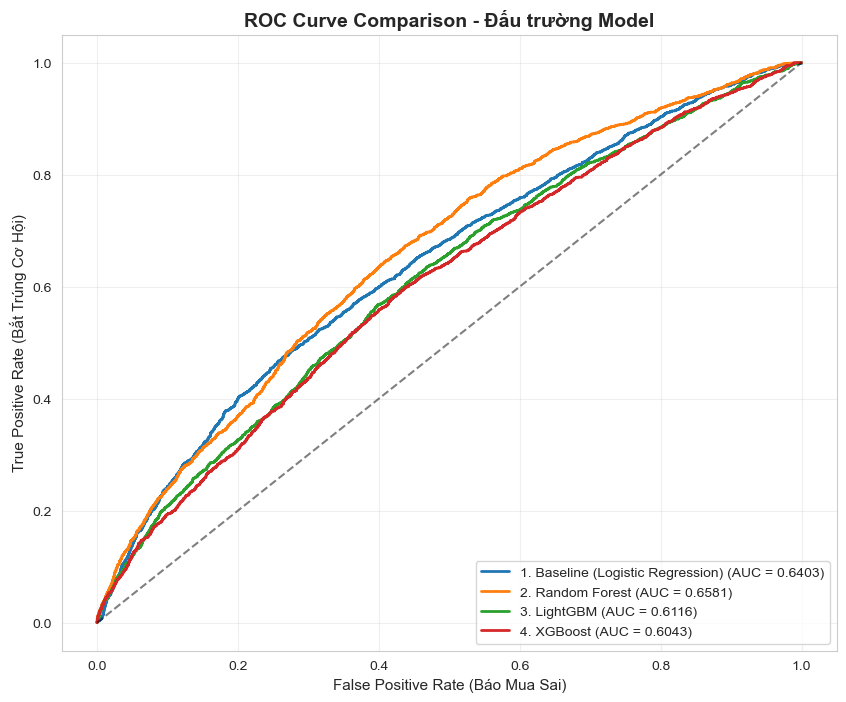

🕵️‍♀️ DEEP DIVE INTO WINNER: 2. Random Forest


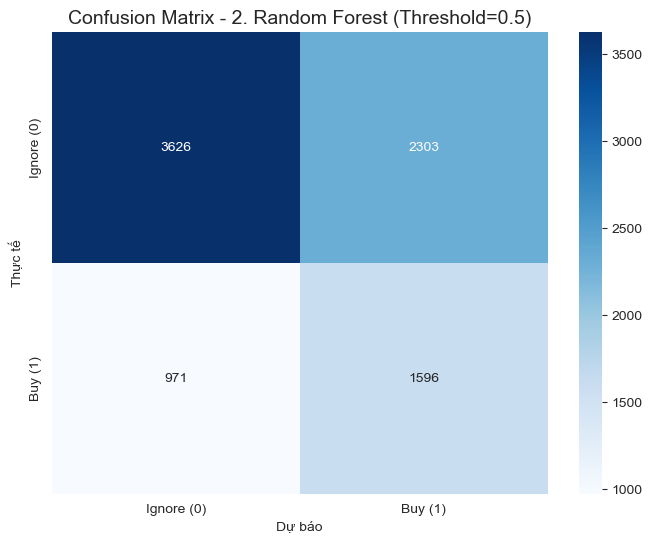


📋 SƠ BỘ HIỆU NĂNG (Ở ngưỡng mặc định 0.5):
              precision    recall  f1-score   support

      Ignore       0.79      0.61      0.69      5929
         Buy       0.41      0.62      0.49      2567

    accuracy                           0.61      8496
   macro avg       0.60      0.62      0.59      8496
weighted avg       0.67      0.61      0.63      8496


⚠️ LƯU Ý QUAN TRỌNG:
- Kết quả trên chỉ là ở ngưỡng 0.5 mặc định.
- Đừng lo nếu Precision thấp, chúng ta sẽ tối ưu Threshold ở bước tiếp theo!


In [327]:
# ==========================================
# 1. SO SÁNH ROC CURVE (TẤT CẢ MODEL)
# ==========================================
plt.figure(figsize=(10, 8))

for name, result in model_results.items():
    model = result['model']
    # Lấy xác suất từ kết quả đã lưu
    y_scores = result['val_probs'] 
    
    # Tính FPR, TPR
    fpr, tpr, _ = roc_curve(y_val, y_scores)
    auc_score = result['val_auc']
    
    plt.plot(fpr, tpr, label=f'{name} (AUC = {auc_score:.4f})', linewidth=2)

# Đường chéo tham chiếu (Random Guess)
plt.plot([0, 1], [0, 1], 'k--', alpha=0.5)
plt.xlabel('False Positive Rate (Báo Mua Sai)', fontsize=11)
plt.ylabel('True Positive Rate (Bắt Trúng Cơ Hội)', fontsize=11)
plt.title('ROC Curve Comparison - Đấu trường Model', fontsize=14, fontweight='bold')
plt.legend(loc='lower right')
plt.grid(alpha=0.3)
plt.show()

# ==========================================
# 2. PHÂN TÍCH CHI TIẾT BEST MODEL (WINNER)
# ==========================================
print("="*60)
print(f"🕵️‍♀️ DEEP DIVE INTO WINNER: {best_model_name}")
print("="*60)

# Lấy thông tin model thắng cuộc
winner_probs = model_results[best_model_name]['val_probs']

# Dự đoán tạm thời ở ngưỡng 0.5 để xem sơ bộ
y_pred_temp = (winner_probs >= 0.5).astype(int)

# A. Confusion Matrix
cm = confusion_matrix(y_val, y_pred_temp)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Ignore (0)', 'Buy (1)'],
            yticklabels=['Ignore (0)', 'Buy (1)'])
plt.title(f'Confusion Matrix - {best_model_name} (Threshold=0.5)', fontsize=14)
plt.ylabel('Thực tế')
plt.xlabel('Dự báo')
plt.show()

# B. Classification Report
print("\n📋 SƠ BỘ HIỆU NĂNG (Ở ngưỡng mặc định 0.5):")
print(classification_report(y_val, y_pred_temp, target_names=['Ignore', 'Buy']))

print("\n⚠️ LƯU Ý QUAN TRỌNG:")
print("- Kết quả trên chỉ là ở ngưỡng 0.5 mặc định.")
print("- Đừng lo nếu Precision thấp, chúng ta sẽ tối ưu Threshold ở bước tiếp theo!")

## 5. Deep Dive into Winner Model (TBD)

🕵️‍♀️ ĐANG PHÂN TÍCH CHI TIẾT: 2. Random Forest


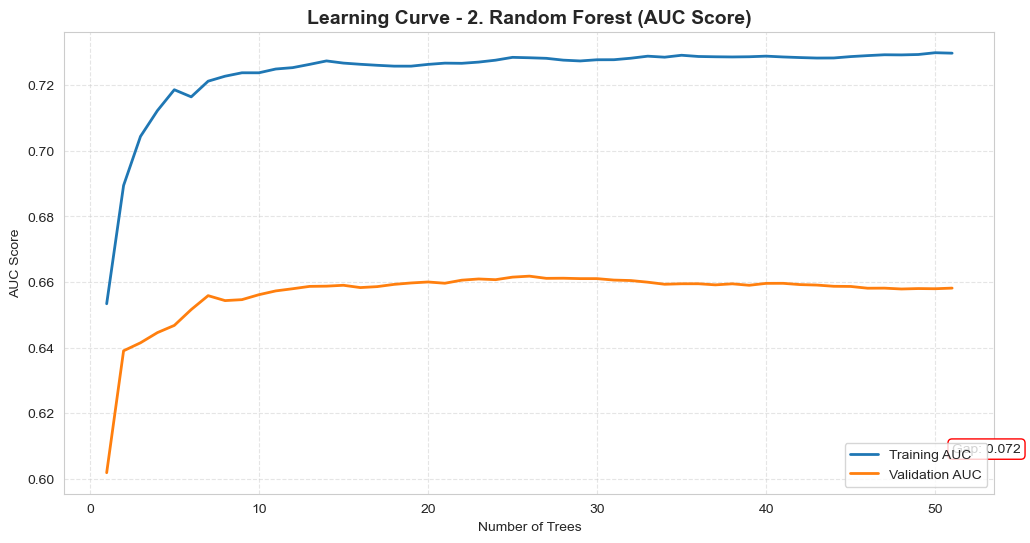

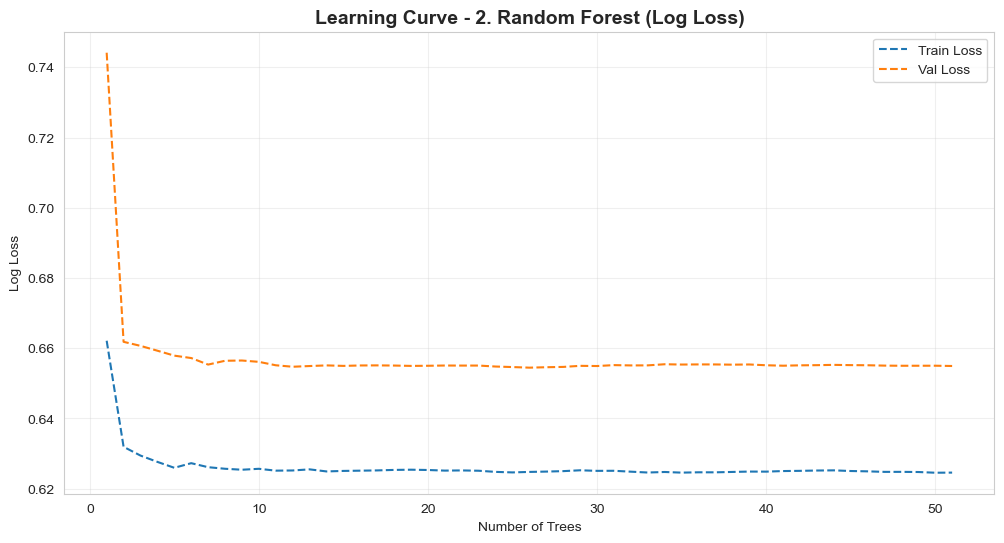

💡 NHẬN XÉT LEARNING CURVE:
✅ TỐT: Model học ổn định. Gap nhỏ (< 10%).


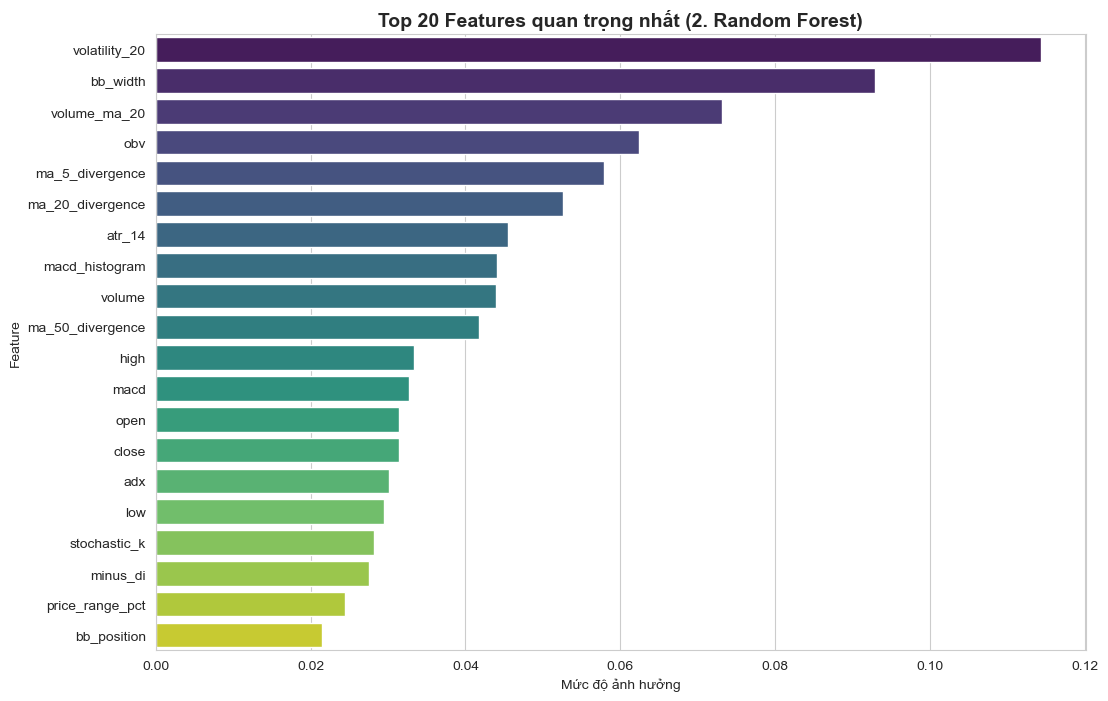

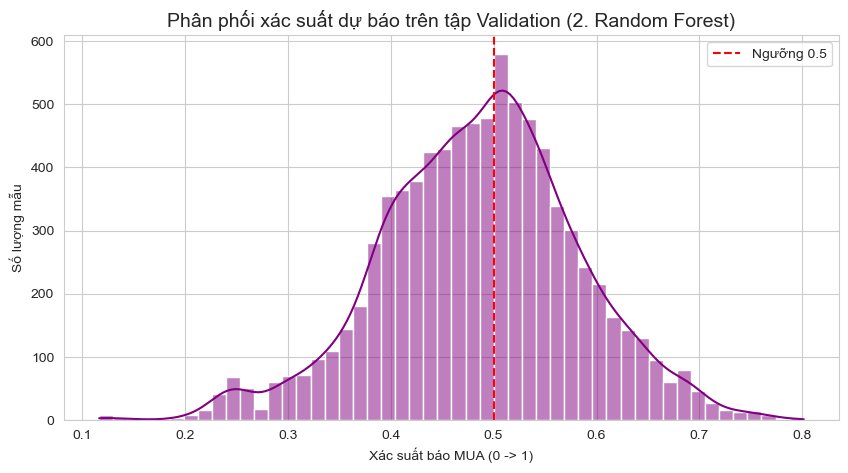

In [330]:
# ==========================================
# PHASE 3: DEEP DIVE - PHÂN TÍCH MODEL (UPDATED)
# ==========================================
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# Lấy thông tin model thắng cuộc
winner_name = best_model_name
winner_entry = model_results[winner_name]
winner_model = winner_entry['model']
history = winner_entry['history']

print(f"🕵️‍♀️ ĐANG PHÂN TÍCH CHI TIẾT: {winner_name}")
print("="*60)

# ---------------------------------------------------------
# 1. LEARNING CURVE (TIẾN TRÌNH HỌC TẬP)
# ---------------------------------------------------------
if history is not None:
    plt.figure(figsize=(12, 6))
    
    train_metric, val_metric = [], []
    xlabel_text = 'Iterations'
    
    # --- TRƯỜNG HỢP 1: RANDOM FOREST (Mới cập nhật) ---
    if 'Random Forest' in winner_name:
        # History của RF có dạng {'train_auc': [...], 'val_auc': [...]}
        train_metric = history['train_auc']
        val_metric = history['val_auc']
        xlabel_text = 'Number of Trees'

    # --- TRƯỜNG HỢP 2: XGBOOST ---
    elif 'XGB' in winner_name:
        # XGBoost keys: validation_0 (train), validation_1 (val)
        results = history
        keys = list(results.keys())
        # Lấy metric đầu tiên tìm thấy (thường là auc)
        metric_name = list(results[keys[0]].keys())[0]
        train_metric = results[keys[0]][metric_name]
        val_metric = results[keys[1]][metric_name]
        xlabel_text = 'Boosting Rounds'
        
    # --- TRƯỜNG HỢP 3: LIGHTGBM ---
    elif 'LightGBM' in winner_name:
        # LightGBM keys: training, valid_1
        results = history
        metric_name = list(results['training'].keys())[0]
        train_metric = results['training'][metric_name]
        val_metric = results['valid_1'][metric_name]
        xlabel_text = 'Boosting Rounds'

    # Vẽ biểu đồ AUC
    epochs = range(1, len(train_metric) + 1)
    plt.plot(epochs, train_metric, label='Training AUC', color='#1f77b4', linewidth=2) # Xanh
    plt.plot(epochs, val_metric, label='Validation AUC', color='#ff7f0e', linewidth=2)  # Cam
    
    plt.title(f'Learning Curve - {winner_name} (AUC Score)', fontsize=14, fontweight='bold')
    plt.xlabel(xlabel_text)
    plt.ylabel('AUC Score')
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.5)
    
    # Highlight Gap
    final_gap = train_metric[-1] - val_metric[-1]
    plt.annotate(f'Gap: {final_gap:.3f}', 
                 xy=(epochs[-1], val_metric[-1]), 
                 xytext=(epochs[-1], val_metric[-1]-0.05),
                 bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="red", lw=1))
    plt.show()

    # (Optional) VẼ THÊM BIỂU ĐỒ LOSS NẾU LÀ RANDOM FOREST
    if 'Random Forest' in winner_name and 'train_loss' in history:
        plt.figure(figsize=(12, 6))
        plt.plot(epochs, history['train_loss'], label='Train Loss', linestyle='--')
        plt.plot(epochs, history['val_loss'], label='Val Loss', linestyle='--')
        plt.title(f'Learning Curve - {winner_name} (Log Loss)', fontsize=14, fontweight='bold')
        plt.xlabel('Number of Trees')
        plt.ylabel('Log Loss')
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.show()
    
    # Nhận xét tự động
    print(f"💡 NHẬN XÉT LEARNING CURVE:")
    if final_gap > 0.1:
        print("⚠️ CẢNH BÁO: Model bị Overfitting (Học vẹt). Gap > 10%.")
    else:
        print("✅ TỐT: Model học ổn định. Gap nhỏ (< 10%).")

else:
    print("ℹ️ Model này (Logistic Regression) không hỗ trợ vẽ Learning Curve theo iterations.")

# ---------------------------------------------------------
# 2. FEATURE IMPORTANCE
# ---------------------------------------------------------
plt.figure(figsize=(12, 8))
importances = None

if hasattr(winner_model, 'feature_importances_'):
    importances = winner_model.feature_importances_
elif hasattr(winner_model, 'coef_'): 
    importances = abs(winner_model.coef_[0])

if importances is not None:
    # Lấy tên cột từ X_train.columns cho chắc chắn
    feat_names = X_train.columns if hasattr(X_train, 'columns') else feature_cols
    
    feat_imp = pd.DataFrame({
        'Feature': feat_names,
        'Importance': importances
    }).sort_values('Importance', ascending=False).head(20)

    sns.barplot(x='Importance', y='Feature', data=feat_imp, palette='viridis')
    plt.title(f'Top 20 Features quan trọng nhất ({winner_name})', fontsize=14, fontweight='bold')
    plt.xlabel('Mức độ ảnh hưởng')
    plt.show()

# ---------------------------------------------------------
# 3. PROBABILITY DISTRIBUTION
# ---------------------------------------------------------
plt.figure(figsize=(10, 5))
# Dùng dữ liệu val_probs đã lưu trong model_results
sns.histplot(winner_entry['val_probs'], bins=50, kde=True, color='purple')
plt.axvline(x=0.5, color='red', linestyle='--', label='Ngưỡng 0.5')
plt.title(f'Phân phối xác suất dự báo trên tập Validation ({winner_name})', fontsize=14)
plt.xlabel('Xác suất báo MUA (0 -> 1)')
plt.ylabel('Số lượng mẫu')
plt.legend()
plt.show()

## 6. TỐI ƯU NGƯỠNG (THRESHOLD TUNING)

🎯 ĐANG TÌM NGƯỠNG TỐI ƯU CHO: 2. Random Forest
Threshold  Precision (Win Rate)      Recall (Capture)     # Trades (Val) 
---------------------------------------------------------------------------
0.60       53.54%                  19.71%              945
0.62       55.77%                  14.88%              685
0.64       59.79%                  10.95%              470
0.66       58.72%                  6.82%              298
0.68       61.69%                  4.83%              201
0.70       67.71%                  2.53%              96
0.72       75.00%                  1.64%              56
0.74       82.35%                  1.09%              34
0.76       92.31%                  0.47%              13
0.78       100.00%                  0.16%              4
0.80       100.00%                  0.08%              2
---------------------------------------------------------------------------
🏆 NGƯỠNG ĐƯỢC CHỌN (BEST THRESHOLD): 0.76
   (Tiêu chí: Precision cao nhất với ít nhất 10 lệ

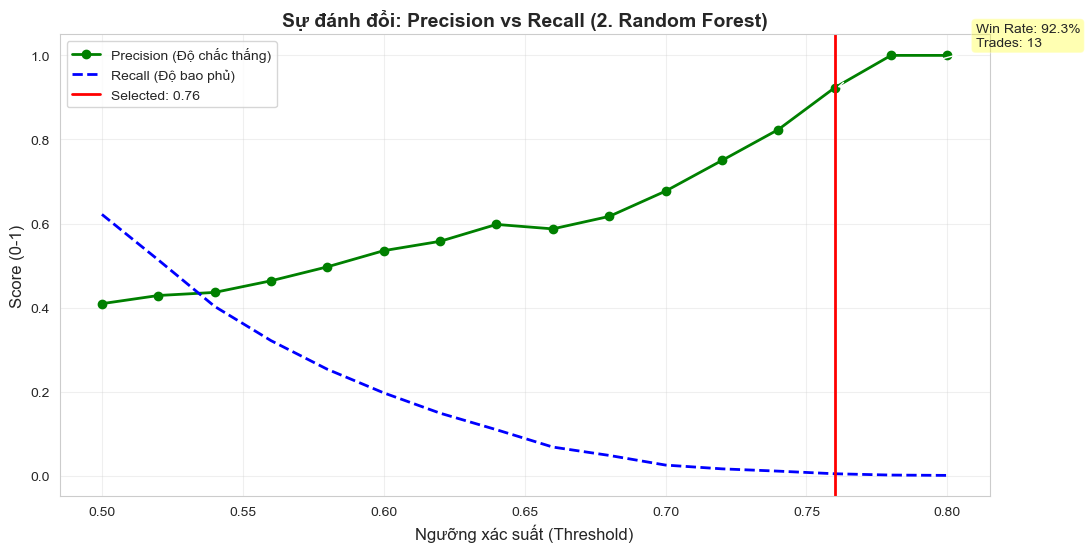

In [331]:
# 1. Lấy dữ liệu từ Model tốt nhất
winner_name = best_model_name
# Lấy xác suất dự báo trên tập Validation (đã lưu ở Phase 2)
y_probs_val = model_results[winner_name]['val_probs'] 
y_true_val = y_val # Nhãn thực tế của tập Validation

# 2. Chạy mô phỏng các ngưỡng từ 0.5 đến 0.95
thresholds = np.arange(0.50, 0.96, 0.02)
results = []

print(f"🎯 ĐANG TÌM NGƯỠNG TỐI ƯU CHO: {winner_name}")
print(f"{'Threshold':<10} {'Precision (Win Rate)':<25} {'Recall (Capture)':<20} {'# Trades (Val)':<15}")
print("-" * 75)

best_threshold = 0.5
best_score = 0 
min_trades = 10 # Yêu cầu tối thiểu phải có 10 lệnh trong tập Val để đảm bảo thống kê

for t in thresholds:
    # Quyết định mua nếu xác suất >= t
    y_pred_t = (y_probs_val >= t).astype(int)
    
    num_trades = y_pred_t.sum()
    
    # Chỉ tính toán nếu có ít nhất 1 lệnh mua
    if num_trades > 0:
        precision = precision_score(y_true_val, y_pred_t, zero_division=0)
        recall = recall_score(y_true_val, y_pred_t, zero_division=0)
        
        # In ra màn hình để theo dõi (chỉ in những ngưỡng có Win Rate > 50%)
        if precision > 0.5:
            print(f"{t:.2f}       {precision:.2%}                  {recall:.2%}              {num_trades}")
        
        results.append({
            'Threshold': t,
            'Precision': precision,
            'Recall': recall,
            'Trades': num_trades
        })
        
        # --- TIÊU CHÍ CHỌN BEST THRESHOLD ---
        # Logic: Chọn ngưỡng có Precision cao nhất 
        # nhưng phải thỏa mãn số lượng lệnh >= min_trades (để tránh may mắn ngẫu nhiên)
        if num_trades >= min_trades:
            # Nếu Precision ngang nhau, chọn cái nào có Recall cao hơn
            if precision > best_score:
                best_score = precision
                best_threshold = t
            elif precision == best_score:
                # Nếu Win Rate bằng nhau, chọn ngưỡng nào mua được nhiều hơn
                # (Logic: Thà giết nhầm còn hơn bỏ sót nếu độ an toàn như nhau)
                pass 

print("-" * 75)
print(f"🏆 NGƯỠNG ĐƯỢC CHỌN (BEST THRESHOLD): {best_threshold:.2f}")
print(f"   (Tiêu chí: Precision cao nhất với ít nhất {min_trades} lệnh)")

# ==========================================
# 3. TRỰC QUAN HÓA SỰ ĐÁNH ĐỔI (TRADE-OFF)
# ==========================================
df_thresh = pd.DataFrame(results)

if not df_thresh.empty:
    plt.figure(figsize=(12, 6))
    
    plt.plot(df_thresh['Threshold'], df_thresh['Precision'], label='Precision (Độ chắc thắng)', color='green', linewidth=2, marker='o')
    plt.plot(df_thresh['Threshold'], df_thresh['Recall'], label='Recall (Độ bao phủ)', color='blue', linewidth=2, linestyle='--')
    
    # Vẽ đường thẳng chỉ vị trí Best Threshold
    plt.axvline(x=best_threshold, color='red', linestyle='-', linewidth=2, label=f'Selected: {best_threshold:.2f}')
    
    plt.title(f'Sự đánh đổi: Precision vs Recall ({winner_name})', fontsize=14, fontweight='bold')
    plt.xlabel('Ngưỡng xác suất (Threshold)', fontsize=12)
    plt.ylabel('Score (0-1)', fontsize=12)
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Thêm chú thích text
    best_row = df_thresh[df_thresh['Threshold'] == best_threshold].iloc[0]
    plt.annotate(f"Win Rate: {best_row['Precision']:.1%}\nTrades: {int(best_row['Trades'])}",
                 xy=(best_threshold, best_row['Precision']),
                 xytext=(best_threshold+0.05, best_row['Precision']+0.1),
                 arrowprops=dict(facecolor='black', arrowstyle='->'),
                 bbox=dict(boxstyle="round,pad=0.3", fc="yellow", alpha=0.3))
    
    plt.show()
else:
    print("⚠️ Không tìm được ngưỡng nào khả thi (Model quá thận trọng hoặc data quá khó).")